# 📊 Customer Churn Prediction - Full ML Pipeline

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline  # ✅ NOT sklearn.pipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [107]:
# 📂 Step 1: Load Dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')  
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


 🔍 Step 2: Basic EDA

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [113]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [115]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

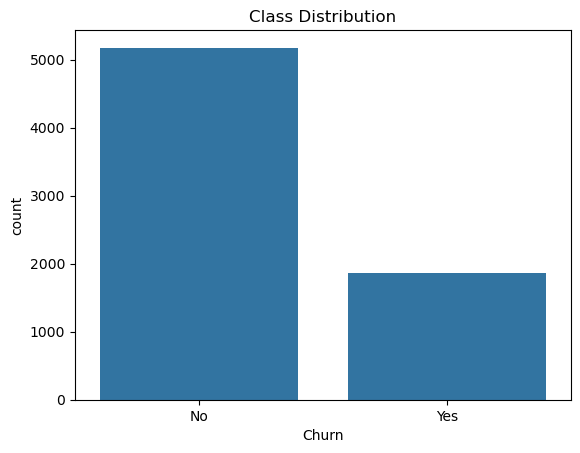

In [117]:
sns.countplot(x='Churn', data=df)
plt.title("Class Distribution")
plt.show()

In [119]:
# 🧹 Step 3: Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df = df[df['Churn'].isin(['Yes', 'No'])]  # Keep only rows with valid values
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)



In [121]:
print("Total rows in df:", len(df))
print("Churn value counts:\n", df['Churn'].value_counts(dropna=False))


Total rows in df: 7043
Churn value counts:
 Churn
0    5174
1    1869
Name: count, dtype: int64


In [93]:
# 🏗️ Step 4: Feature Engineering
categorical = df.select_dtypes(include='object').columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical.remove('Churn')

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical),
    ('num', numerical_pipeline, numerical)
])

In [95]:
# 🧪 Step 5: Train-Test Split + Handle Imbalance
# 🎯 Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# 📤 Train-Test Split (before resampling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🧼 Apply preprocessing to X (fit on training only)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# ⚖️ SMOTE - now works because X is numeric
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)


In [97]:
# ✅ Use pipeline with preprocessing → SMOTE → classifier
clf = Pipeline([
    ('preprocessor', preprocessor),  # Your ColumnTransformer
    ('smote', SMOTE(random_state=42)),  # Oversample only after preprocessing
    ('classifier', RandomForestClassifier(random_state=42))
])

# ✅ Fit on raw training data (DataFrame)
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1035
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.77      0.77      1409



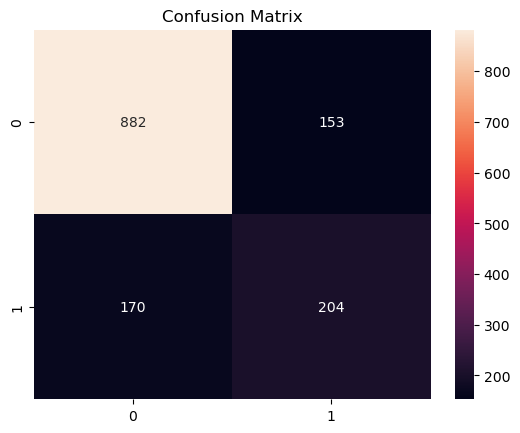

ROC-AUC Score: 0.8147123407992973


In [99]:
# ✅ Step 7: Model Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))